### Objective: Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 4

### Load datasets

In [2]:
people = pd.read_csv('./data/people.csv', parse_dates=['date'])
activity = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
people.shape, activity.shape

((189118, 41), (2197291, 15))

In [3]:
# join dataset by people id
data = activity.merge(people, on='people_id', how='inner', suffixes=('_act', '_ppl'))
data.shape

(2197291, 55)

In [4]:
pd.set_option('display.max_columns', 55)
data.head()

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,char_1_ppl,group_1,char_2_ppl,date_ppl,char_3_ppl,char_4_ppl,char_5_ppl,char_6_ppl,char_7_ppl,char_8_ppl,char_9_ppl,char_10_ppl,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36


### Check the cardinality of each categorical feature

In [5]:
activity.dtypes

people_id                    object
activity_id                  object
date                 datetime64[ns]
activity_category            object
char_1                       object
char_2                       object
char_3                       object
char_4                       object
char_5                       object
char_6                       object
char_7                       object
char_8                       object
char_9                       object
char_10                      object
outcome                       int64
dtype: object

In [6]:
activity[activity.columns - ['people_id', 'activity_id', 'date']].apply(lambda col : len(col.unique()))

activity_category       7
char_1                 52
char_10              6516
char_2                 33
char_3                 12
char_4                  8
char_5                  8
char_6                  6
char_7                  9
char_8                 19
char_9                 20
outcome                 2
dtype: int64

In [7]:
people.dtypes

people_id            object
char_1               object
group_1              object
char_2               object
date         datetime64[ns]
char_3               object
char_4               object
char_5               object
char_6               object
char_7               object
char_8               object
char_9               object
char_10                bool
char_11                bool
char_12                bool
char_13                bool
char_14                bool
char_15                bool
char_16                bool
char_17                bool
char_18                bool
char_19                bool
char_20                bool
char_21                bool
char_22                bool
char_23                bool
char_24                bool
char_25                bool
char_26                bool
char_27                bool
char_28                bool
char_29                bool
char_30                bool
char_31                bool
char_32                bool
char_33             

In [8]:
people[people.columns - ['people_id', 'date']].apply(lambda col : len(col.unique()))

char_1         2
char_10        2
char_11        2
char_12        2
char_13        2
char_14        2
char_15        2
char_16        2
char_17        2
char_18        2
char_19        2
char_2         3
char_20        2
char_21        2
char_22        2
char_23        2
char_24        2
char_25        2
char_26        2
char_27        2
char_28        2
char_29        2
char_3        43
char_30        2
char_31        2
char_32        2
char_33        2
char_34        2
char_35        2
char_36        2
char_37        2
char_38      101
char_4        25
char_5         9
char_6         7
char_7        25
char_8         8
char_9         9
group_1    34224
dtype: int64

### Remove prefix of variables

In [9]:
def remove_prefix(char):
    """Remove the 'type' or 'group' prefix of 'char_*' , 'activity_category', and 'group'
    """
    if char and str(char).startswith('type'):
        return char[5:]
    if char and str(char).startswith('group'):
        return char[6:]
    else:
        return

In [10]:
for col in data.columns[data.dtypes == 'object'] - ['people_id', 'activity_id', 'date_act', 'date_ppl', 'outcome', 'char_38']:
    print 'remove the prefix of feature: {}'.format(col)
    data[col] = data[col].apply(remove_prefix)
    print '======================================='

remove the prefix of feature: activity_category
remove the prefix of feature: char_10_act
remove the prefix of feature: char_1_act
remove the prefix of feature: char_1_ppl
remove the prefix of feature: char_2_act
remove the prefix of feature: char_2_ppl
remove the prefix of feature: char_3_act
remove the prefix of feature: char_3_ppl
remove the prefix of feature: char_4_act
remove the prefix of feature: char_4_ppl
remove the prefix of feature: char_5_act
remove the prefix of feature: char_5_ppl
remove the prefix of feature: char_6_act
remove the prefix of feature: char_6_ppl
remove the prefix of feature: char_7_act
remove the prefix of feature: char_7_ppl
remove the prefix of feature: char_8_act
remove the prefix of feature: char_8_ppl
remove the prefix of feature: char_9_act
remove the prefix of feature: char_9_ppl
remove the prefix of feature: group_1


In [11]:
data.shape

(2197291, 55)

In [12]:
# fillna with as type 0
data.fillna(0, inplace=True)
data.head()

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,char_1_ppl,group_1,char_2_ppl,date_ppl,char_3_ppl,char_4_ppl,char_5_ppl,char_6_ppl,char_7_ppl,char_8_ppl,char_9_ppl,char_10_ppl,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,4,0,0,0,0,0,0,0,0,0,76,0,2,17304,2,2021-06-29,5,5,5,3,11,2,2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,2,0,0,0,0,0,0,0,0,0,1,0,2,17304,2,2021-06-29,5,5,5,3,11,2,2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,2,0,0,0,0,0,0,0,0,0,1,0,2,17304,2,2021-06-29,5,5,5,3,11,2,2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,2,0,0,0,0,0,0,0,0,0,1,0,2,17304,2,2021-06-29,5,5,5,3,11,2,2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,2,0,0,0,0,0,0,0,0,0,1,0,2,17304,2,2021-06-29,5,5,5,3,11,2,2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36


### Data sampling for EDA

In [13]:
# sample 2% of total data for exploratory data analysis
np.random.seed(1234)
random_idx = np.random.choice(activity.index.values, len(data)/50, replace=False)
sample_data = data.iloc[random_idx]
sample_data.shape

(43945, 55)

### Check the label outcome distribution

0    24511
1    19434
Name: outcome, dtype: int64


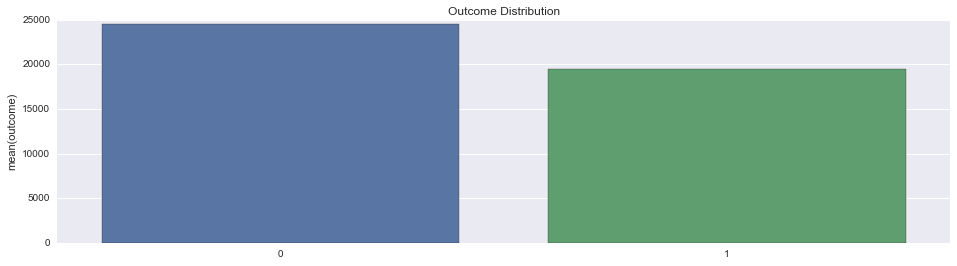

In [14]:
outcome = sample_data.outcome.value_counts()
print outcome
sns.barplot(x= outcome.index, y = outcome)
sns.plt.title('Outcome Distribution')

- The outcome is binary and has a balanced distribution, a good news.

### Check the cardinality of each categorical feature

In [15]:
sample_data[sample_data.columns - ['people_id', 'activity_id', 'outcome', 'date_act', 'date_ppl']].apply(lambda col : len(col.unique()))

activity_category       7
char_10_act          2407
char_10_ppl             2
char_11                 2
char_12                 2
char_13                 2
char_14                 2
char_15                 2
char_16                 2
char_17                 2
char_18                 2
char_19                 2
char_1_act             40
char_1_ppl              2
char_20                 2
char_21                 2
char_22                 2
char_23                 2
char_24                 2
char_25                 2
char_26                 2
char_27                 2
char_28                 2
char_29                 2
char_2_act             28
char_2_ppl              3
char_30                 2
char_31                 2
char_32                 2
char_33                 2
char_34                 2
char_35                 2
char_36                 2
char_37                 2
char_38               101
char_3_act             11
char_3_ppl             41
char_4_act              7
char_4_ppl  

-  char_10_act, char_38, and group_1 have hight cardinalty

### Barplot the features with low cardinality

In [16]:
cgr_cols_low = sample_data.columns - ['people_id', 'activity_id', 'date_act', 'date_ppl', 'char_10_act', 'char_38', 'group_1']

In [17]:
def plot_cgr(cgr_data, cols):
    """function to barplot the categorical features by 'outcome'
    """
    plt.figure(figsize=(16, 4*len(cols)))
    for idx, col in enumerate(cols):
        idx = idx + 1
        ax = plt.subplot(len(cols),1,idx)
        sns.countplot(x=col, hue="outcome", data=cgr_data, ax=ax)
        ax.set_title('Outcome Distribution by {}'.format(col))
    plt.tight_layout()
    plt.show()
    plt.close()

- barplot the activity features with low cardinality

In [18]:
cgr_cols_low_act = filter(None, [col if str(col).endswith('act') else '' for col in cgr_cols_low])
cgr_cols_low_act.append('activity_category')
cgr_cols_low_act

['char_1_act',
 'char_2_act',
 'char_3_act',
 'char_4_act',
 'char_5_act',
 'char_6_act',
 'char_7_act',
 'char_8_act',
 'char_9_act',
 'activity_category']

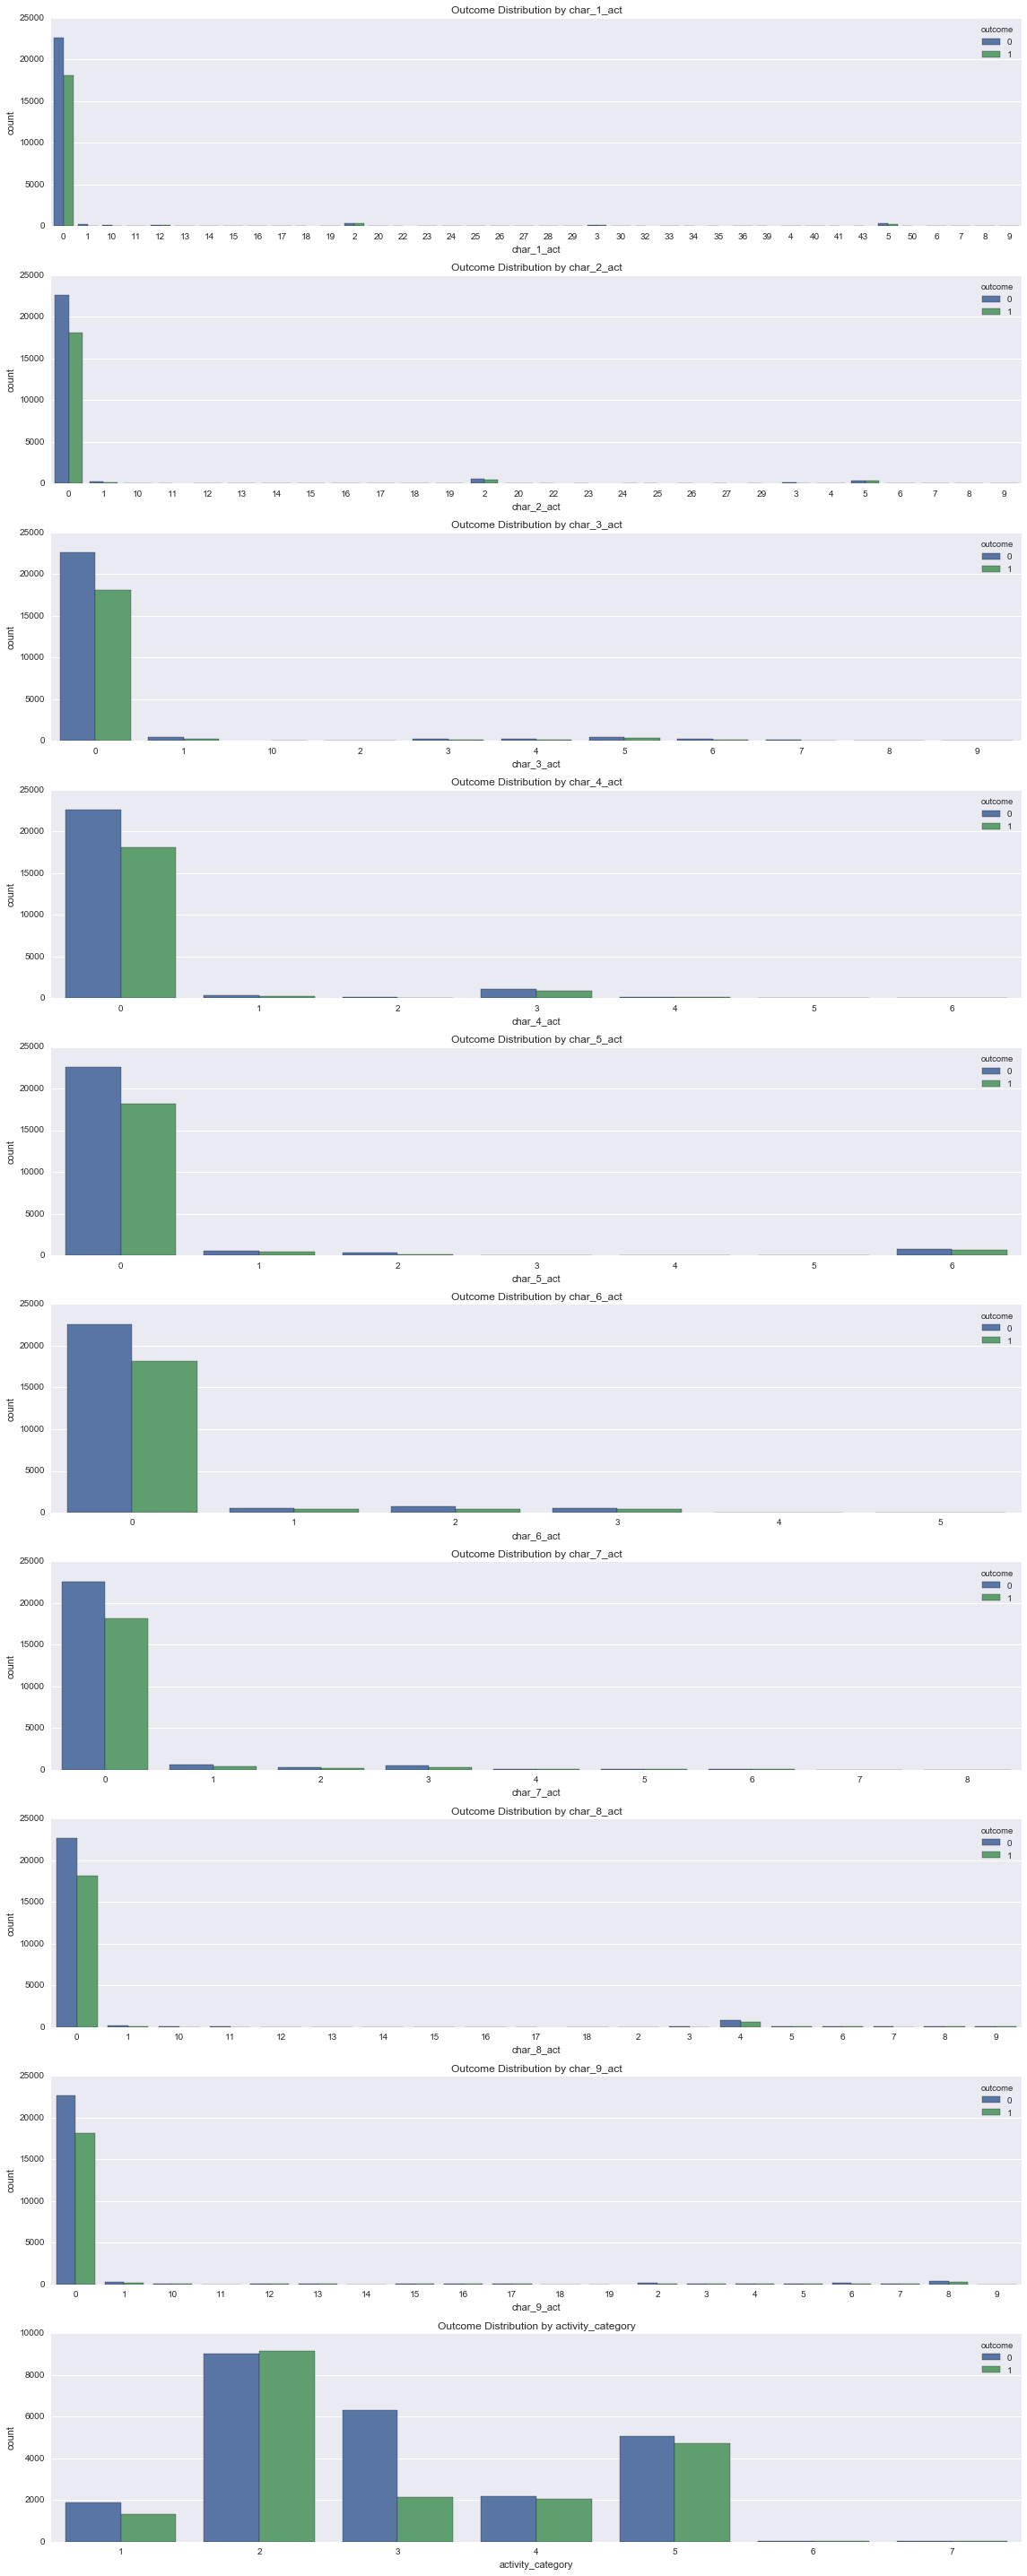

In [19]:
plot_cgr(sample_data, cgr_cols_low_act)

- In actitivty 'char_*', the majority type is 0, the 'NaNs' imputed before
- In the type 0, the outcome is nearly balanced, and outcome 0 exceeds 1 in all features
- 'activity_category' is an exception with more variance across categories

- barplot the people features with low cardinality

In [20]:
cgr_cols_low_ppl = cgr_cols_low - cgr_cols_low_act
cgr_cols_low_ppl = cgr_cols_low_ppl - ['outcome']

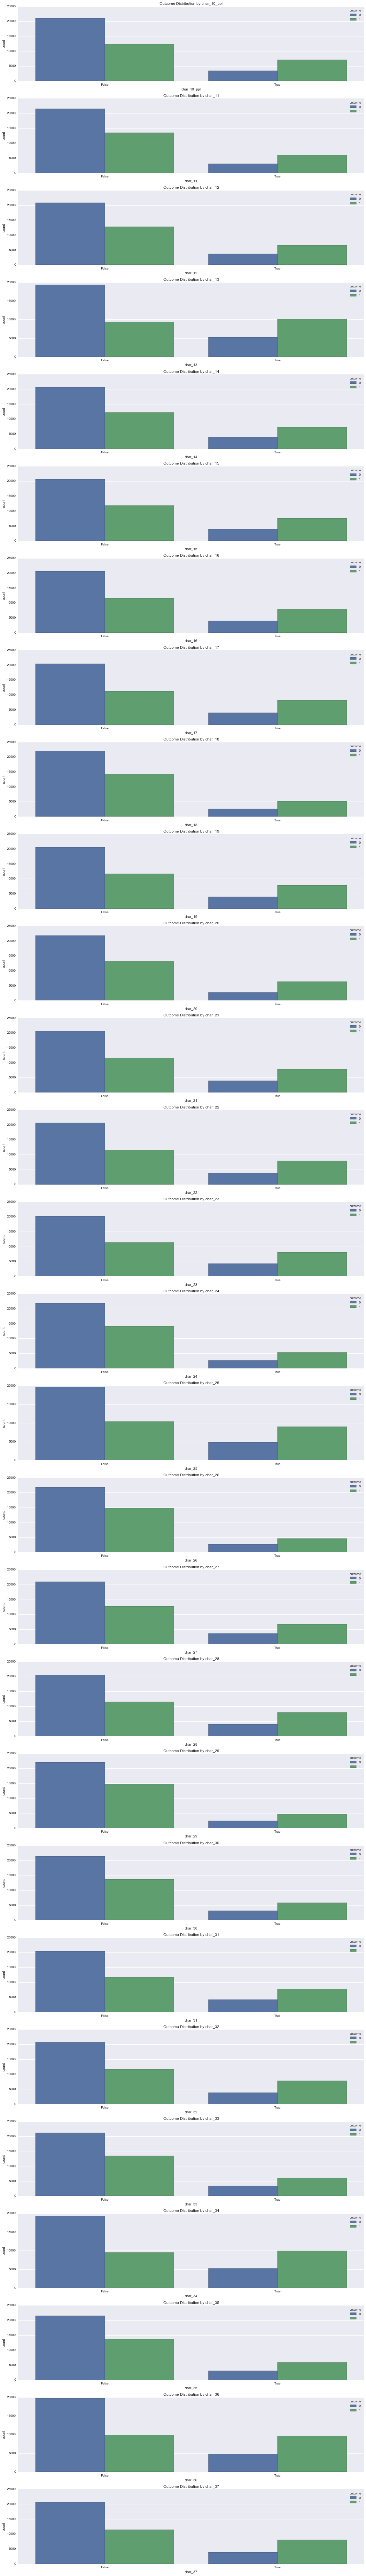

In [21]:
# first barplot the boolean types
cgr_cols_low_ppl_bool = cgr_cols_low_ppl[sample_data[cgr_cols_low_ppl].dtypes == 'bool']
plot_cgr(sample_data, cgr_cols_low_ppl_bool)

- Boolean types have pretty similar structure between 'False' and 'True'.
- 'False' exceeds 'True' in total volumn
- The outcome within each boolean characteristic is opposite position, in another way, False tends to end up with 0 outcome, while 'True' tends to end up with  1 outcome.

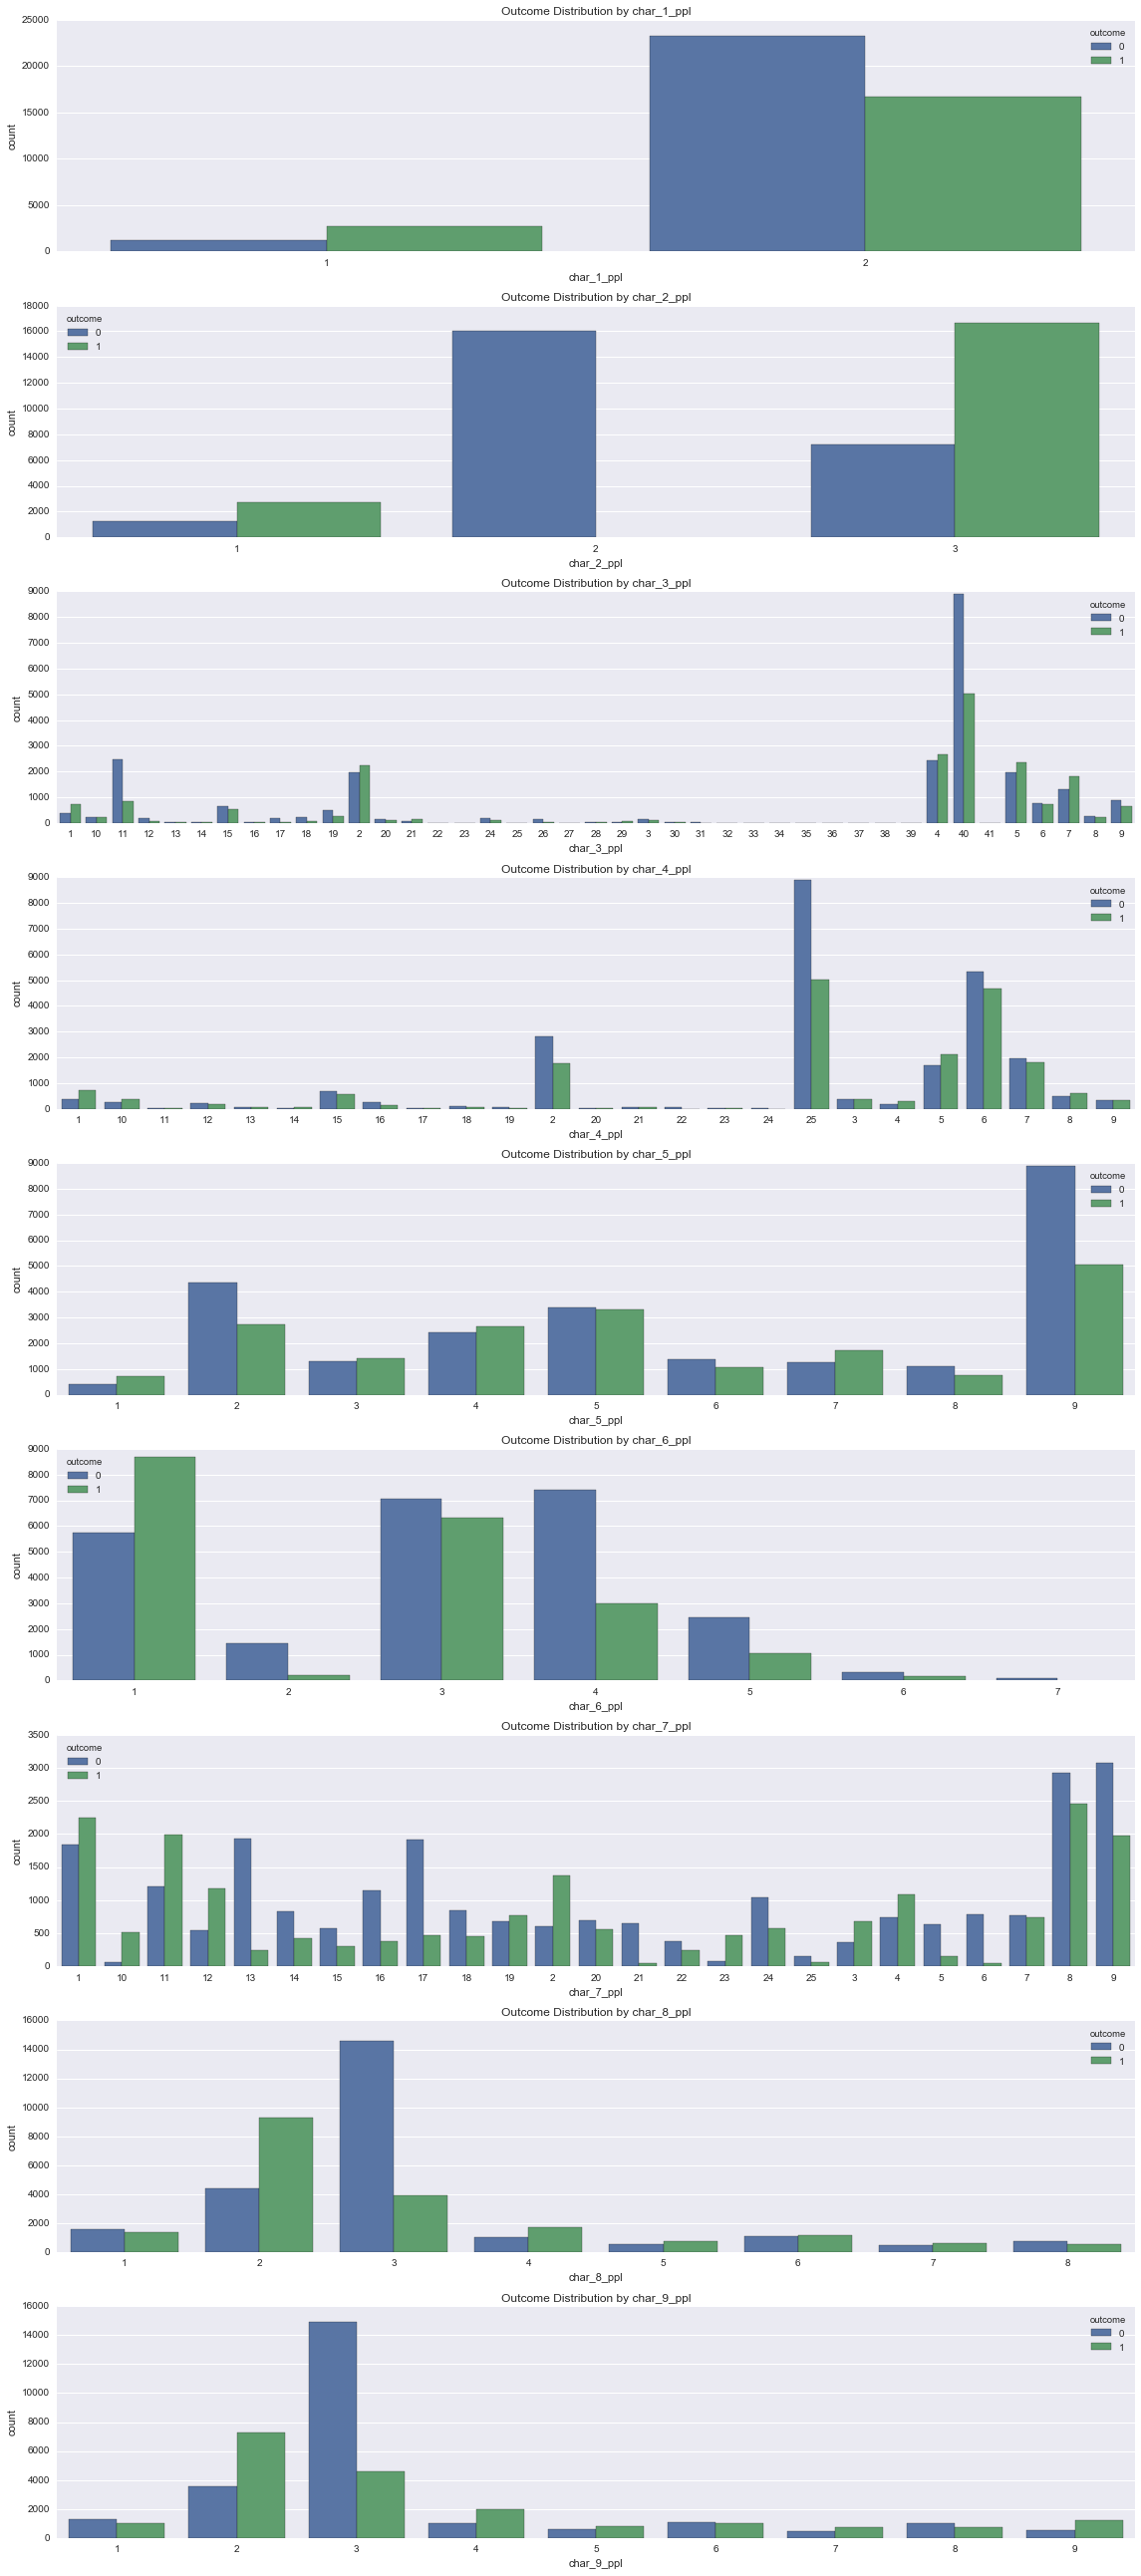

In [22]:
# second, barplot the non-boolean features of people
cgr_cols_low_ppl_nonbool = cgr_cols_low_ppl[sample_data[cgr_cols_low_ppl].dtypes != 'bool']
plot_cgr(sample_data, cgr_cols_low_ppl_nonbool)

- Non-boolean features are more variant in each features, which could provide important information for the modeling.

### Barplot the features with high cardinality

In [23]:
cgr_cols_high = ['char_10_act', 'char_38', 'group_1']

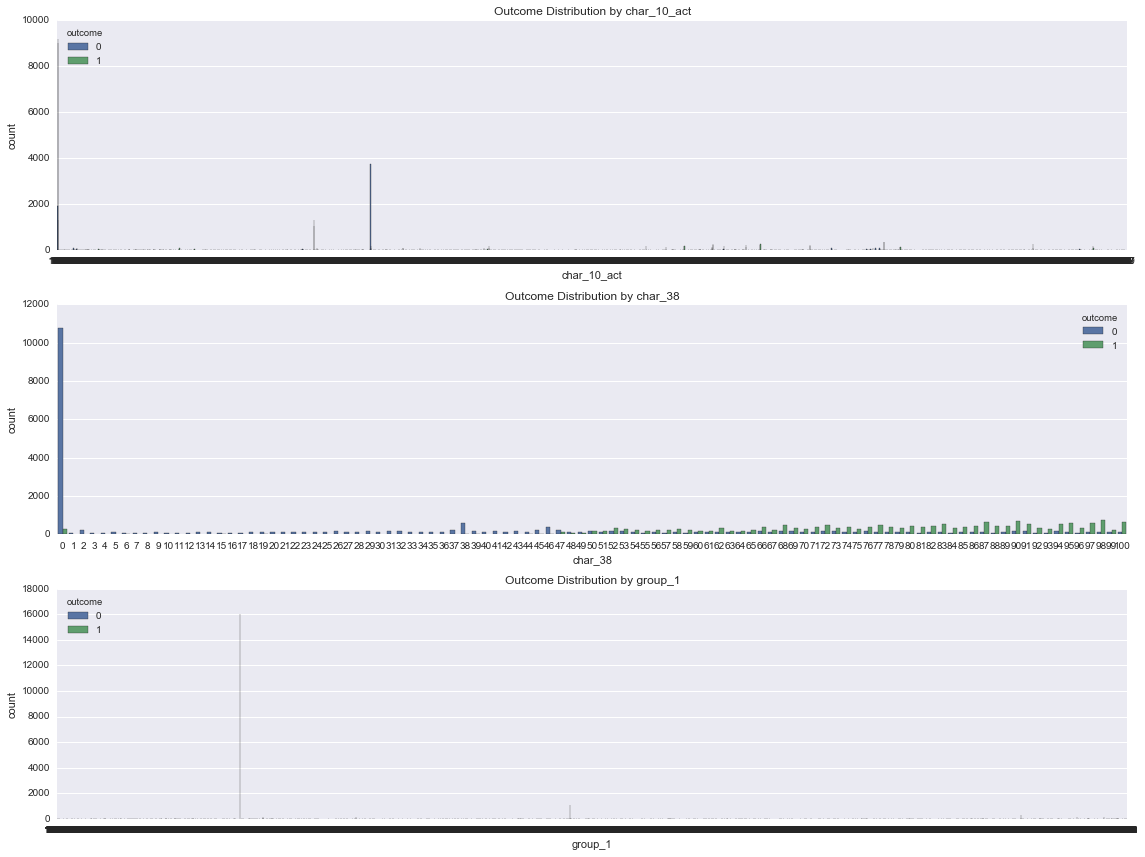

In [34]:
plot_cgr(sample_data, cgr_cols_high)

- All three features have a few extreme high values

### Check the datatime features

In [42]:
# prepare the activity date mean and size
date_act = pd.DataFrame()
date_act['outcome 0'] = sample_data[sample_data.outcome == 0].groupby('date_act')['outcome'].size()
date_act['outcome 1'] = sample_data[sample_data.outcome == 1].groupby('date_act')['outcome'].size()

In [43]:
# prepare the people date mean and size
date_ppl = pd.DataFrame()
date_ppl['outcome 0'] = sample_data[sample_data.outcome == 0].groupby('date_ppl')['outcome'].size()
date_ppl['outcome 1'] = sample_data[sample_data.outcome == 1].groupby('date_ppl')['outcome'].size()

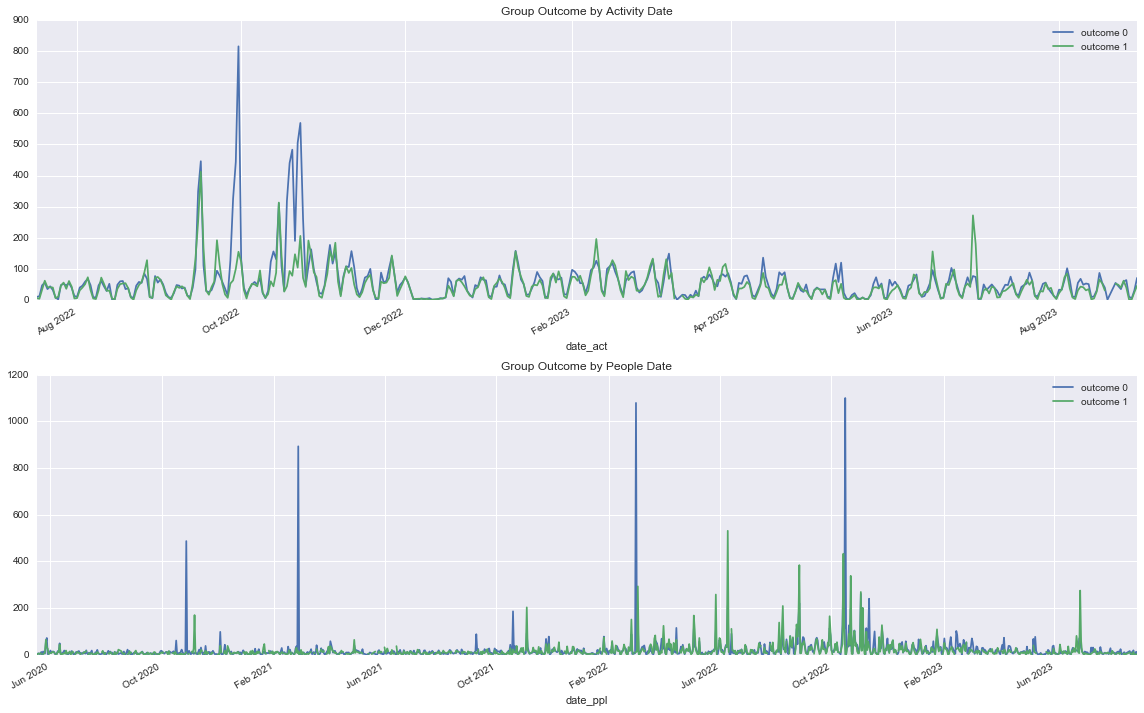

In [44]:
plt.figure()
ax1 = plt.subplot(2,1,1)
date_act.plot(figsize=(16, 10), ax=ax1)
ax1.set_title('Group Outcome by Activity Date')
           
ax2 = plt.subplot(2,1,2)
date_ppl.plot(figsize=(16, 10), ax=ax2)
ax2.set_title('Group Outcome by People Date')


plt.tight_layout()
plt.show()
plt.close()

- The data covers three years records between 2020 and 2023.
- The outcome vibrates periodically along the time series. We can go deeper later to find out if it's weekly or monthly. 
- The blue line(outcome proba) vibrates around 0.5, showing either 1 or 0 occurs evenly

- Plot outcome by week and month

In [42]:
sample_data['dayofweek']= sample_data['date_act'].dt.dayofweek
week_act = pd.DataFrame()
week_act['outcome_proba'] = sample_data.groupby('dayofweek')['outcome'].mean()
week_act['outcome_count'] = sample_data.groupby('dayofweek')['outcome'].size()

In [43]:
sample_data['month'] = sample_data['date_act'].dt.month
month_act = pd.DataFrame()
month_act['outcome_proba'] = sample_data.groupby('month')['outcome'].mean()
month_act['outcome_count'] = sample_data.groupby('month')['outcome'].size()

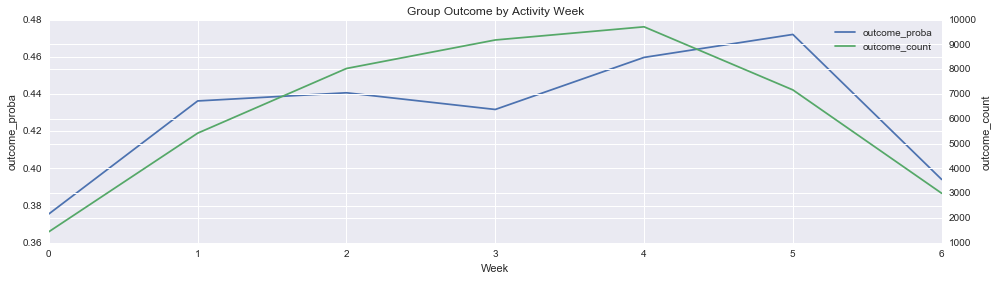

In [114]:
plt.figure()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
line1 = ax1.plot(week_act.index, week_act.outcome_proba, 'b-')
line2 = ax2.plot(week_act.index, week_act.outcome_count, 'g-')


ax1.set_xlabel('Week')
ax1.set_ylabel('outcome_proba')
ax1.legend(loc=1)
ax1.set_title('Group Outcome by Activity Week')

# added these three lines
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc=0)

ax2.set_ylabel('outcome_count')

plt.show()

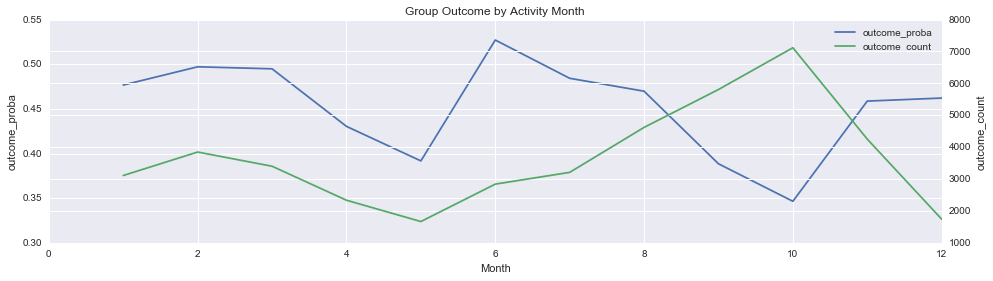

In [115]:
plt.figure()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
line1 = ax1.plot(month_act.index, month_act.outcome_proba, 'b-')
line2 = ax2.plot(month_act.index, month_act.outcome_count, 'g-')


ax1.set_xlabel('Month')
ax1.set_ylabel('outcome_proba')
ax1.legend(loc=1)
ax1.set_title('Group Outcome by Activity Month')

# added these three lines
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc=0)

ax2.set_ylabel('outcome_count')

plt.show()

- It turns out the outcome follows similar weekly trend and opposite monthly trend(after May) in proba and count 

In [45]:
sample_data['dayofweek']= sample_data['date_ppl'].dt.dayofweek
week_ppl = pd.DataFrame()
week_ppl['outcome_proba'] = sample_data.groupby('dayofweek')['outcome'].mean()
week_ppl['outcome_count'] = sample_data.groupby('dayofweek')['outcome'].size()

In [46]:
sample_data['month'] = sample_data['date_ppl'].dt.month
month_ppl = pd.DataFrame()
month_ppl['outcome_proba'] = sample_data.groupby('month')['outcome'].mean()
month_ppl['outcome_count'] = sample_data.groupby('month')['outcome'].size()

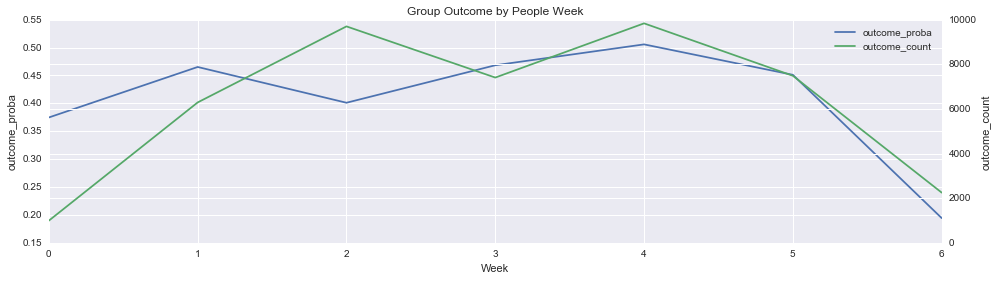

In [117]:
plt.figure()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
line1 = ax1.plot(week_ppl.index, week_ppl.outcome_proba, 'b-')
line2 = ax2.plot(week_ppl.index, week_ppl.outcome_count, 'g-')


ax1.set_xlabel('Week')
ax1.set_ylabel('outcome_proba')
ax1.legend(loc=1)
ax1.set_title('Group Outcome by People Week')

# added these three lines
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc=0)

ax2.set_ylabel('outcome_count')

plt.show()

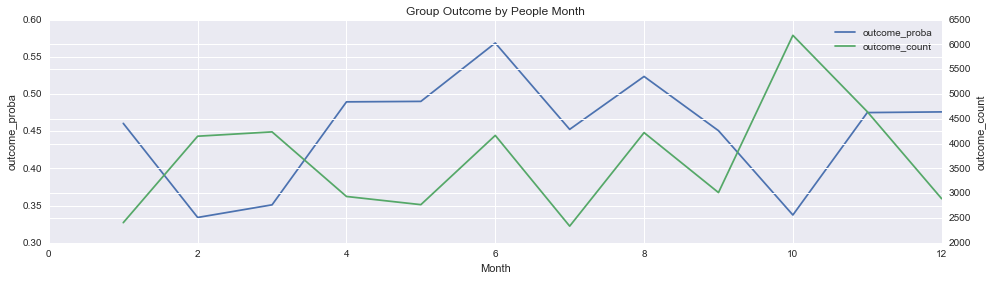

In [118]:
plt.figure()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
line1 = ax1.plot(month_ppl.index, month_ppl.outcome_proba, 'b-')
line2 = ax2.plot(month_ppl.index, month_ppl.outcome_count, 'g-')


ax1.set_xlabel('Month')
ax1.set_ylabel('outcome_proba')
ax1.legend(loc=1)
ax1.set_title('Group Outcome by People Month')

# added these three lines
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc=0)

ax2.set_ylabel('outcome_count')

plt.show()

- The similar weely trend in people dataset as the activity dataset. But, the month trend is quite same beteen May and September rather than after May in activity set.
- Hence, the datetime pattern is important as to the outcome.

### Check indexing features people_id and activity_id

In [119]:
people_id = sample_data.groupby('people_id')['outcome'].mean()
# people_id['outcome_count'] = sample_data.groupby('people_id')['outcome'].size()

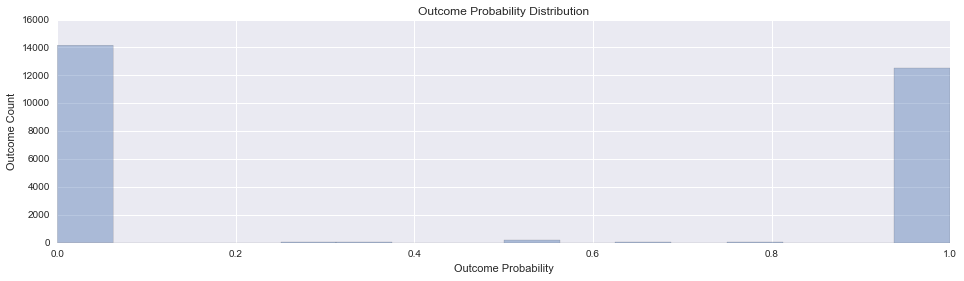

In [121]:
sns.distplot(people_id, kde=False)
sns.plt.title('Outcome Probability Distribution')
sns.plt.xlabel('Outcome Probability')
sns.plt.ylabel('Outcome Count')

- It seems like some people always go into 0 outcome and some into 1 outcome. And Both almost share the whole outcome.

### Check 'people_id' and 'activity_id' in the test set

In [50]:
act_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])

In [51]:
print len(set(act_test.people_id).intersection(set(people.people_id))) # how many unique people_id are from train data
print len(act_test.people_id.unique()) # how many unique people are from the test data

37823
37823


- The people from test data are from the people of train data

In [38]:
set(act_test.activity_id).intersection(set(activity.activity_id))

set()

- The activity are totally different from train and test data

### Hence, the problem scope is clear now, that is to predict new activity outcomes of the same people with known activities.

### Drop the sample data and save out the train data

In [39]:
train_data = data.drop(random_idx, axis=0)
train_data.shape

(2153346, 55)

In [40]:
train_data.to_csv('./train_data.csv', index=False)

### Construct the test data by joining people and test data

In [41]:
# join dataset by people id
test_data = act_test.merge(people, on='people_id', how='inner', suffixes=('_act', '_ppl'))
test_data.shape

(498687, 54)

In [42]:
# remove the prefix
for col in test_data.columns[test_data.dtypes == 'object'] - ['people_id', 'activity_id', 'date_act', 'date_ppl', 'char_38']:
    print 'remove the prefix of feature: {}'.format(col)
    test_data[col] = test_data[col].apply(remove_prefix)
    print '======================================='

remove the prefix of feature: activity_category
remove the prefix of feature: char_10_act
remove the prefix of feature: char_1_act
remove the prefix of feature: char_1_ppl
remove the prefix of feature: char_2_act
remove the prefix of feature: char_2_ppl
remove the prefix of feature: char_3_act
remove the prefix of feature: char_3_ppl
remove the prefix of feature: char_4_act
remove the prefix of feature: char_4_ppl
remove the prefix of feature: char_5_act
remove the prefix of feature: char_5_ppl
remove the prefix of feature: char_6_act
remove the prefix of feature: char_6_ppl
remove the prefix of feature: char_7_act
remove the prefix of feature: char_7_ppl
remove the prefix of feature: char_8_act
remove the prefix of feature: char_8_ppl
remove the prefix of feature: char_9_act
remove the prefix of feature: char_9_ppl
remove the prefix of feature: group_1


In [43]:
# fillna with as type 0
test_data.fillna(0, inplace=True)
test_data.head()

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100004,act1_249281,2022-07-20,1,5,10,5,1,6,1,...,True,True,True,True,True,True,True,True,True,76
1,ppl_100004,act2_230855,2022-07-20,5,0,0,0,0,0,0,...,True,True,True,True,True,True,True,True,True,76
2,ppl_10001,act1_240724,2022-10-14,1,12,1,5,4,6,1,...,False,True,True,True,True,True,True,True,True,90
3,ppl_10001,act1_83552,2022-11-27,1,20,10,5,4,6,1,...,False,True,True,True,True,True,True,True,True,90
4,ppl_10001,act2_1043301,2022-10-15,5,0,0,0,0,0,0,...,False,True,True,True,True,True,True,True,True,90


In [44]:
# write out test data
test_data.to_csv('./data/test_data.csv', index=False)